In [ ]:
import numpy as np
import pandas as pd
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr



In [ ]:

file_path = r"C:/Users/marta/OneDrive\Documenti/UNI/Climate change seminar/ERA5/ERA5_subset_rotated_scores.csv"

# Load CSV into a DataFrame
df = pd.read_csv(file_path)

print("Original column names:", df.columns.tolist())

df.columns = [col.strip('"\'').strip() for col in df.columns]
print("Cleaned column names:", df.columns.tolist())

# Extract component columns and time column
component_columns = [col for col in df.columns if col.startswith('V')]
time_column = 'time'

print(f"Number of component columns: {len(component_columns)}")
print(f"Component columns: {component_columns}")
print(f"Time column exists: {'time' in df.columns}")

df = df.dropna()
print(f"DataFrame shape after dropping NAs: {df.shape}")

try:
    df.set_index(time_column, inplace=True, drop=True)
    print("Time column set as index successfully")
except KeyError as e:
    print(f"Error setting index: {e}")
    time_col_candidates = [col for col in df.columns if 'time' in col.lower()]
    if time_col_candidates:
        time_column = time_col_candidates[0]
        print(f"Using {time_column} as time column instead")
        df.set_index(time_column, inplace=True, drop=True)
    else:
        print("No time column found, creating a sequence index")
        df.index = np.arange(len(df))

data_values = df[component_columns].values
print(f"Data values shape: {data_values.shape}")

var_names = [f"V{i+1}" for i in range(data_values.shape[1])]
print(f"var_names length: {len(var_names)}")

dataframe = pp.DataFrame(data_values, var_names=var_names)
print(f"Tigramite dataframe dimensions: {dataframe.N} variables x {dataframe.T} time points")

tau_min = 1
tau_max = 5
pc_alpha = 0.0001  # Standard value, not too strict

cond_ind_test = ParCorr()

pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=1)
print("PCMCI initialized successfully")

print("Running PCMCI algorithm...")
results = pcmci.run_pcmci(tau_min=tau_min, tau_max=tau_max, pc_alpha=pc_alpha)
print("PCMCI algorithm completed")

# Extract results
p_matrix = results['p_matrix']
val_matrix = results['val_matrix']


Original column names: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'time']
Cleaned column names: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'time']
Number of component columns: 30
Component columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30']
Time column exists: True
DataFrame shape after dropping NAs: (481, 31)
Time column set as index successfully
Data values shape: (481, 30)
var_names length: 30
Tigramite dataframe dimensions: 30 variables x {0: 481} time points
PCMCI initialized successfully
Running PCMCI algorithm.

In [4]:
print(f"Number of significant links: {np.sum(p_matrix < 0.0001)}")
print(f"Minimum p-value: {np.min(p_matrix)}")
print(f"p_matrix shape: {p_matrix.shape}")

def significant_links_summary_csv(p_matrix, val_matrix, var_names, alpha_level=0.05, output_file='C:/Users/marta/OneDrive/Documenti/UNI/Climate change seminar/ERA5/significant_links_summary.csv'):
    """
    Create a summary of significant links and save to CSV
    """
    N, _, tau_max_plus_1 = p_matrix.shape
    
    rows = []
    
    for target_idx in range(N):
        target_name = var_names[target_idx]
        
        links = []
        for source_idx in range(N):
            source_name = var_names[source_idx]
            for tau in range(1, tau_max_plus_1):  # Skip lag 0
                if p_matrix[source_idx, target_idx, tau] <= alpha_level:
                    links.append((
                        source_name, 
                        -tau, 
                        p_matrix[source_idx, target_idx, tau], 
                        val_matrix[source_idx, target_idx, tau]
                    ))
        
        links.sort(key=lambda x: x[2])
        
        rows.append({
            'target': target_name,
            'num_links': len(links),
            'links_description': '; '.join([
                f"({src} {lag}): p={p:.5f}, val={val:.3f}"
                for src, lag, p, val in links
            ])
        })
    
    # Convert to DataFrame and save
    df = pd.DataFrame(rows)
    df.to_csv(output_file, index=False)
    print(f"Summary saved to {output_file}")
    
    return df

summary_df = significant_links_summary_csv(
    p_matrix=p_matrix, 
    val_matrix=val_matrix, 
    var_names=var_names,
    alpha_level=0.0001, 
    output_file='C:/Users/marta/OneDrive/Documenti/UNI/Climate change seminar/ERA5/significant_links_summary.csv'
)

print(f"Number of significant links: {np.sum(p_matrix < 0.0001)}")


Number of significant links: 106
Minimum p-value: 1.471596391712625e-166
p_matrix shape: (30, 30, 6)
Summary saved to C:/Users/marta/OneDrive/Documenti/UNI/Climate change seminar/ERA5/significant_links_summary.csv
Number of significant links: 106


Network visualization saved to C:/Users/marta/OneDrive/Documenti/UNI/Climate change seminar/ERA5/enhanced_causal_network.png


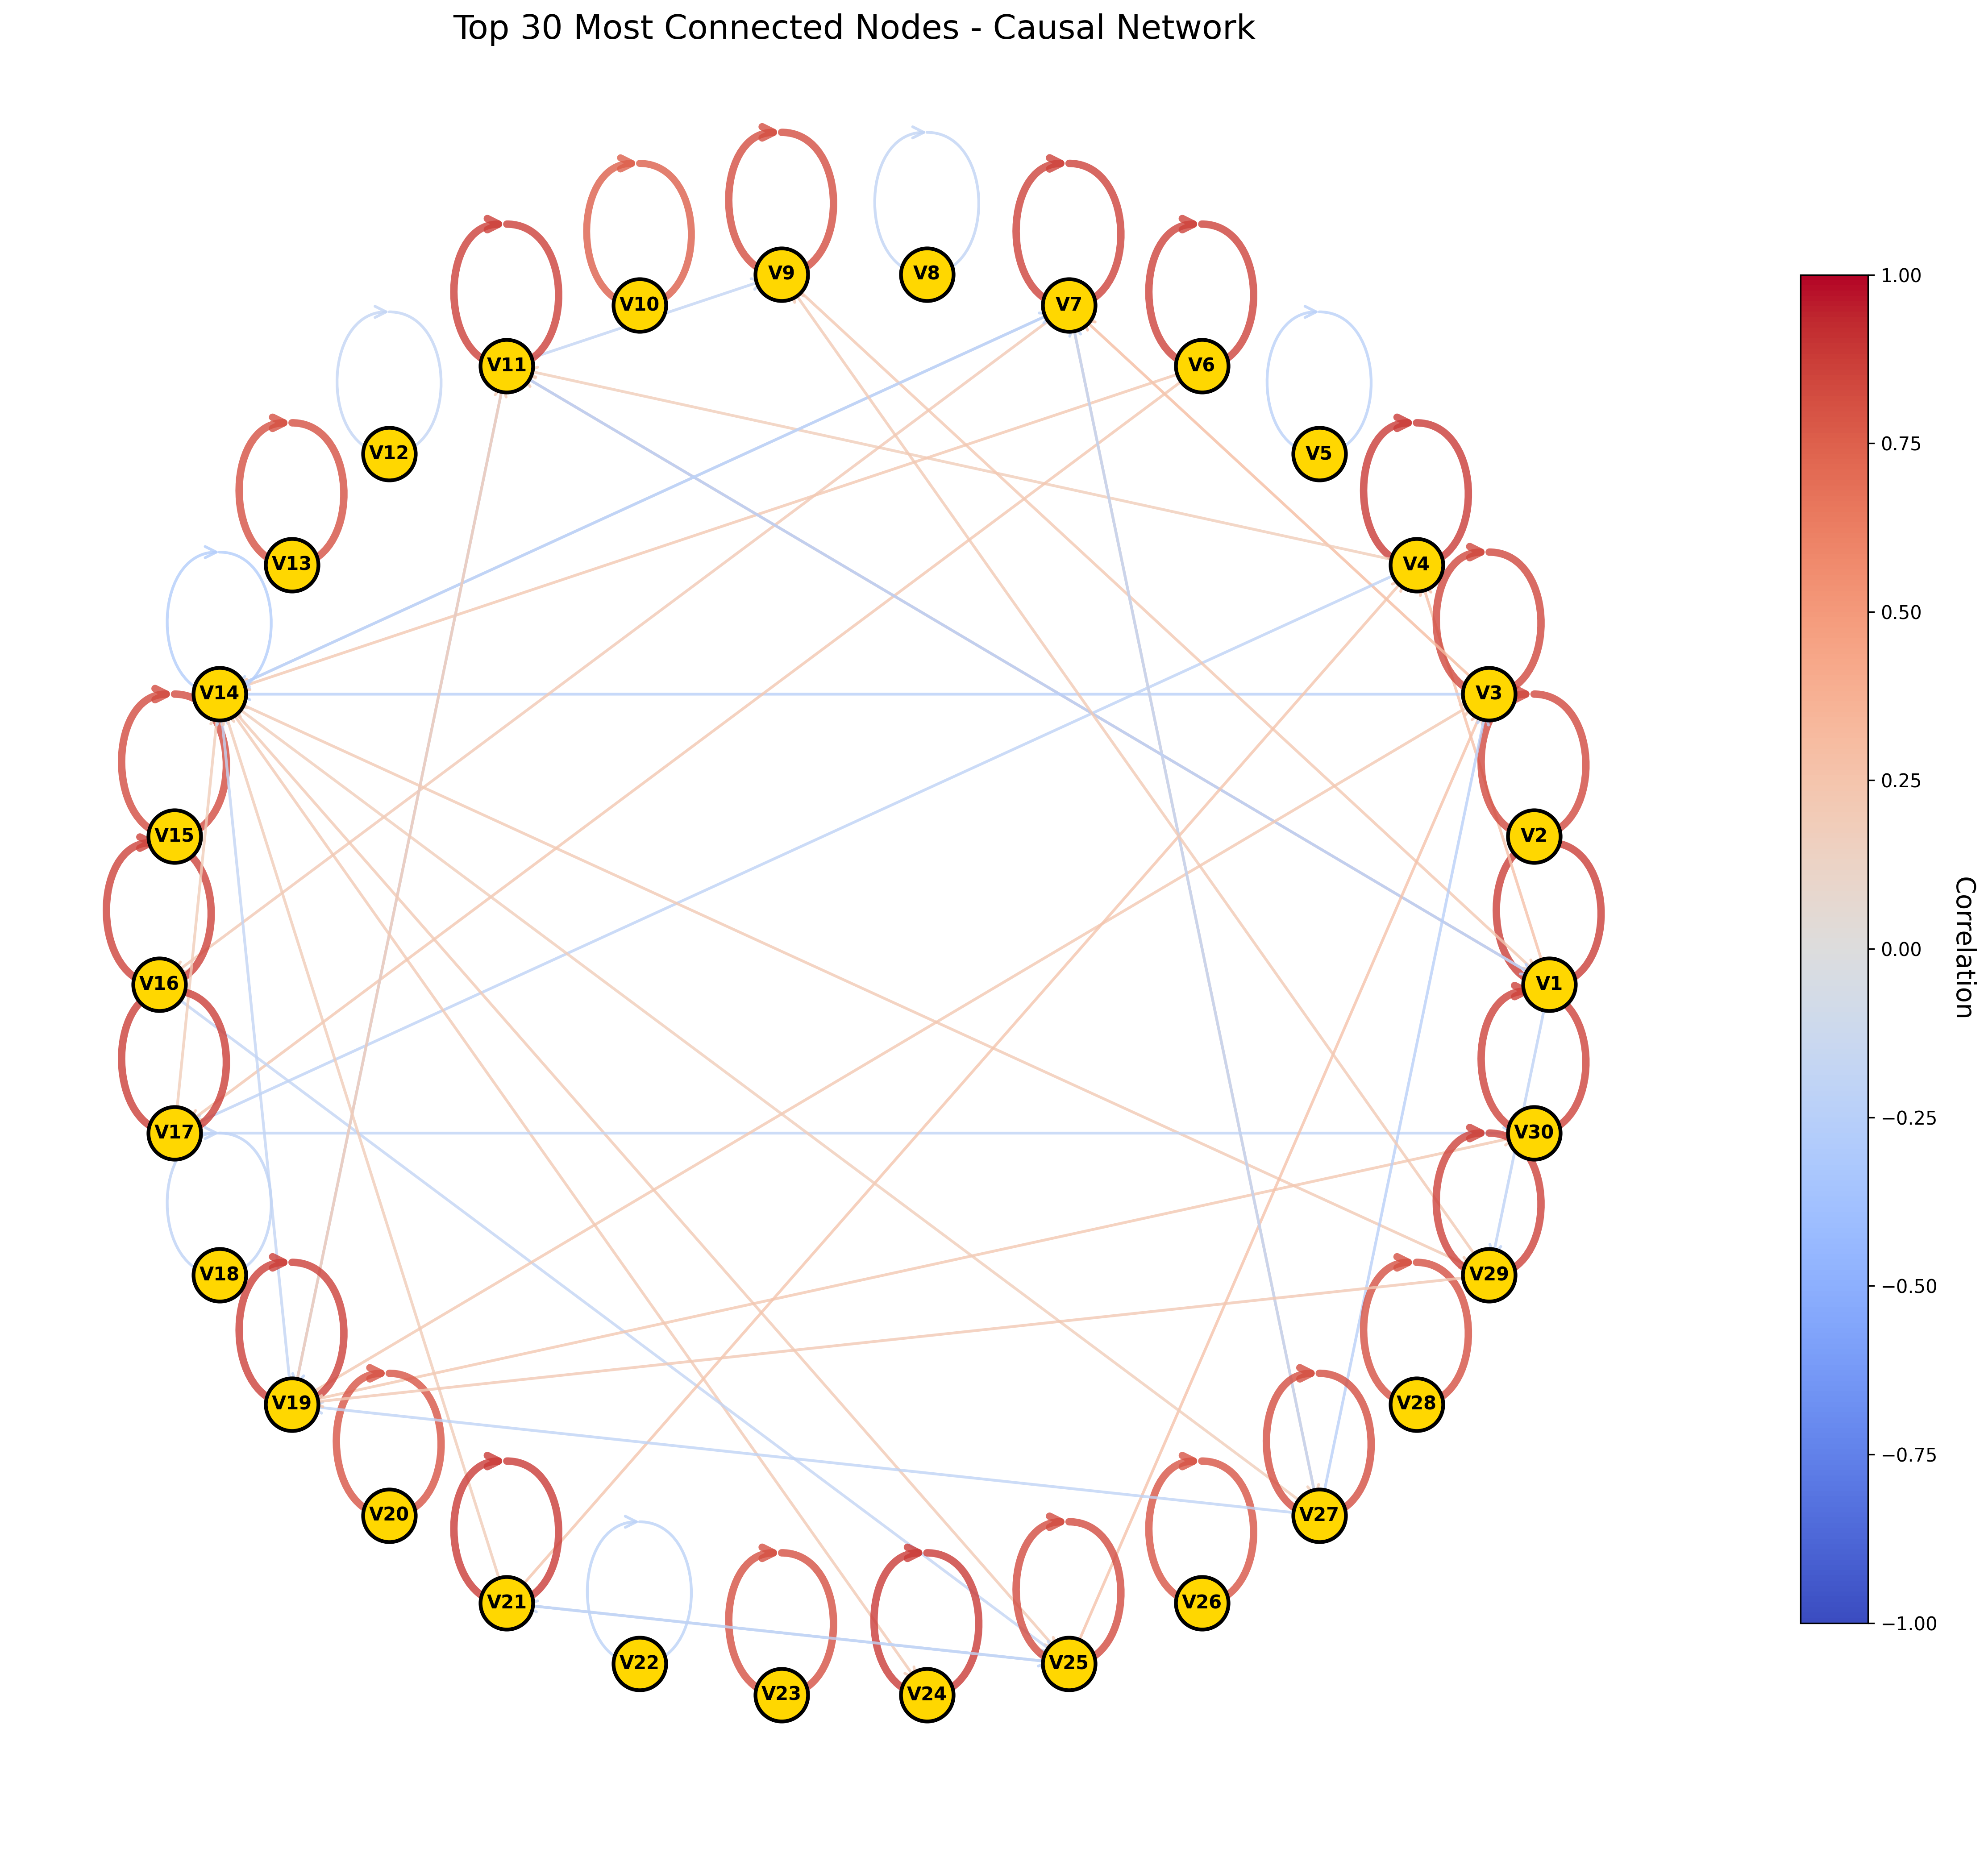

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def create_circular_causal_network(p_matrix, val_matrix, var_names, alpha_level=0.0001, 
                                  output_file='C:/Users/marta/OneDrive/Documenti/UNI/Climate change seminar/ERA5/circular_causal_network.png'):
    """
    Create a circular visualization of the causal network with more visible links
    """
    N, _, tau_max_plus_1 = p_matrix.shape
    
    G = nx.DiGraph()
    
    for i, name in enumerate(var_names):
        G.add_node(name, index=i)
    
    edges = []
    for i in range(N):
        for j in range(N):
            for tau in range(1, tau_max_plus_1):
                if p_matrix[i, j, tau] <= alpha_level:
                    edges.append((
                        var_names[i], 
                        var_names[j], 
                        {
                            'weight': abs(val_matrix[i, j, tau]),
                            'tau': tau,
                            'p_value': p_matrix[i, j, tau],
                            'correlation': val_matrix[i, j, tau]  # Can be positive or negative
                        }
                    ))
    
    for source, target, attr in edges:
        G.add_edge(source, target, **attr)
    
    node_degrees = dict(G.degree())
    sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)
    
    top_nodes = [node for node, _ in sorted_nodes[:min(30, len(sorted_nodes))]]
    
    if not top_nodes:
        print("No significant links found. Cannot create visualization.")
        return
    
    H = G.subgraph(top_nodes)
    
    fig, ax = plt.subplots(figsize=(16, 14), dpi=300)
    
    # Calculate node positions in a circle
    pos = nx.circular_layout(H)
    
    edge_colors = []
    edge_widths = []
    
    for u, v, data in H.edges(data=True):
        edge_colors.append(data['correlation'])
        edge_widths.append(max(1.5, min(4.0, abs(data['correlation']) * 5)))
    
    cmap = cm.coolwarm
    norm = Normalize(vmin=-1, vmax=1)
    
    edges = nx.draw_networkx_edges(
        H, pos, 
        ax=ax,  # Specify the axis
        width=edge_widths,
        edge_color=edge_colors,
        edge_cmap=cmap,
        edge_vmin=-1,
        edge_vmax=1,
        alpha=0.8,  # Increased opacity
        arrowsize=15,  # Larger arrows for visibility
        arrowstyle='->'
    )
    
    nodes = nx.draw_networkx_nodes(
        H, pos, 
        ax=ax,  # Specify the axis
        node_size=800,  # Increased node size
        node_color='gold',
        edgecolors='black',
        linewidths=2.0  # Thicker node outlines
    )
    
    labels = {node: node for node in H.nodes()}
    nx.draw_networkx_labels(
        H, pos, 
        ax=ax,  # Specify the axis
        labels=labels,
        font_size=10,  # Larger font
        font_weight='bold',
        font_color='black'
    )
    
    ax.set_title(f"Top {len(top_nodes)} Most Connected Nodes - Causal Network", fontsize=18)
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.75, pad=0.05)
    cbar.set_label('Correlation', rotation=270, labelpad=20, fontsize=14)
    
    ax.axis('off')
    
    # Add a border around the plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    
    plt.tight_layout()
    
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Network visualization saved to {output_file}")
    
    return H

try:
    circular_graph = create_circular_causal_network(
        p_matrix=p_matrix, 
        val_matrix=val_matrix, 
        var_names=var_names,
        alpha_level=0.0001,
        output_file='C:/Users/marta/OneDrive/Documenti/UNI/Climate change seminar/ERA5/enhanced_causal_network.png'
    )
    
except Exception as e:
    print(f"Error creating visualization: {e}")